Libraries

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.models import efficientnet_v2_m, EfficientNet_V2_M_Weights
from torch.utils.data import DataLoader, WeightedRandomSampler
import pickle  
import numpy as np
import os
import shutil
import random
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F
from collections import Counter
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [13]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [14]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [15]:
# Choose the best available device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU (CUDA)")
elif torch.backends.mps.is_built() and torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple MPS (Metal Performance Shaders)")
else:
    device = torch.device("cpu")
    print("Using CPU")

print("Device selected:", device)


Using GPU (CUDA)
Device selected: cuda


In [16]:
# Paths
folder_path = r'D:\SeedLink\Agricultural-crops'
base_dir = r'D:\SeedLink\Agricultural-crops-split'

print(os.listdir(folder_path))
print(os.listdir(base_dir))


['Almond', 'Amaranth', 'Apple', 'Apricot', 'Arecanut', 'Asparagus', 'Avocado', 'Banana', 'Beans', 'Beetroot', 'Bell Pepper', 'Bitter Gourd', 'Black Berry', 'Black Current', 'Blueberry', 'Bottle Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Cardamom', 'Carrot', 'Cashew', 'Cauliflower', 'Cherry', 'Chikoo', 'Chilli', 'Clove', 'Coconut', 'Coffee-plant', 'Corn', 'Cotton', 'Cranberry', 'Cucumber', 'Custard Apple', 'Dates', 'Dragon Fruit', 'Elderberry', 'Fig', 'Fox_nut(Makhana)', 'Garlic', 'Ginger', 'Gooseberry', 'Gram', 'Grapes', 'Guava', 'Jackfruit', 'Jowar', 'Jute', 'Kiwi', 'Lemon', 'Lettuce', 'Litchi', 'Longan', 'Maize', 'Mango', 'Mushroom', 'Muskmelon', 'Mustard-oil', 'Okra', 'Olive', 'Onion', 'Orange', 'Papaya', 'Passion Fruit', 'Peach', 'Pear', 'Pearl_millet(bajra)', 'Peas', 'Pineapple', 'Plum', 'Pomegranate', 'Potato', 'Pumpkin', 'Radish', 'Rice', 'Soyabean', 'Spinach', 'Strawberry', 'Sugarcane', 'Sunflower', 'Sweet Potato', 'Tamarind', 'Taro Roots', 'Tea', 'Tinda', 'Tobacco-

Load and preprocess dataset

In [6]:
# Create directories
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(base_dir, split), exist_ok=True)

classes = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]

for cls in classes:
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

In [25]:
train_dir = r'D:\SeedLink\Agricultural-crops-split\train'

for cls in os.listdir(train_dir):
    cls_path = os.path.join(train_dir, cls)
    n = len(os.listdir(cls_path))
    print(cls, n)


Almond 15
Amaranth 6
Apple 30
Apricot 87
Arecanut 20
Asparagus 20
Avocado 69
Banana 23
Beans 69
Beetroot 66
Bell Pepper 81
Bitter Gourd 81
Black Berry 66
Black Current 63
Blueberry 57
Bottle Gourd 69
Brinjal 63
Broccoli 54
Cabbage 57
Capsicum 66
Cardamom 16
Carrot 54
Cashew 54
Cauliflower 45
Cherry 24
Chikoo 16
Chilli 17
Clove 22
Coconut 18
Coffee-plant 21
Corn 51
Cotton 24
Cranberry 45
Cucumber 23
Custard Apple 54
Dates 63
Dragon Fruit 54
Elderberry 165
Fig 51
Fox_nut(Makhana) 17
Garlic 48
Ginger 51
Gooseberry 66
Gram 18
Grapes 30
Guava 57
Jackfruit 57
Jowar 22
Jute 17
Kiwi 30
Lemon 21
Lettuce 72
Litchi 51
Longan 48
Maize 23
Mango 29
Mushroom 45
Muskmelon 48
Mustard-oil 21
Okra 42
Olive 45
Onion 42
Orange 30
Papaya 17
Passion Fruit 30
Peach 36
Pear 60
Pearl_millet(bajra) 29
Peas 75
Pineapple 18
Plum 26
Pomegranate 45
Potato 57
Pumpkin 45
Radish 15
Rice 21
Soyabean 22
Spinach 60
Strawberry 30
Sugarcane 18
Sunflower 18
Sweet Potato 48
Tamarind 23
Taro Roots 13
Tea 17
Tinda 12
Tobacco-pl

In [17]:
# Split with better ratios
split_ratio = {'train': 0.75, 'val': 0.15, 'test': 0.10}

for cls in classes:
    cls_path = os.path.join(folder_path, cls)
    if not os.path.isdir(cls_path):
        continue
    
    images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(images)
    
    n_total = len(images)
    n_train = int(n_total * split_ratio['train'])
    n_val = int(n_total * split_ratio['val'])
    
    train_images = images[:n_train]
    val_images = images[n_train:n_train + n_val]
    test_images = images[n_train + n_val:]
    
    for img in train_images:
        src = os.path.join(cls_path, img)
        dst = os.path.join(base_dir, 'train', cls, img)
        if not os.path.exists(dst):
            shutil.copy(src, dst)
    
    for img in val_images:
        src = os.path.join(cls_path, img)
        dst = os.path.join(base_dir, 'val', cls, img)
        if not os.path.exists(dst):
            shutil.copy(src, dst)
    
    for img in test_images:
        src = os.path.join(cls_path, img)
        dst = os.path.join(base_dir, 'test', cls, img)
        if not os.path.exists(dst):
            shutil.copy(src, dst)

print("Data splitting completed!")

Data splitting completed!


Enhanced data Augmentation

In [18]:
# More aggressive augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize larger first
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random crop
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomGrayscale(p=0.1),  # Random grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15))  # Random erasing
])

# Test-time augmentation
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Load Datasets with Class Balancing

In [20]:
train_dataset = datasets.ImageFolder(os.path.join(base_dir, 'train'), transform=train_transform)
val_dataset = datasets.ImageFolder(os.path.join(base_dir, 'val'), transform=val_test_transform)
test_dataset = datasets.ImageFolder(os.path.join(base_dir, 'test'), transform=val_test_transform)

# Calculate class weights for handling imbalanced data
class_counts = Counter(train_dataset.targets)
print(f"\nClass distribution (train):")
print(f"Min samples: {min(class_counts.values())}, Max samples: {max(class_counts.values())}")
print(f"Mean samples: {np.mean(list(class_counts.values())):.1f}")

# Stronger class weighting for imbalanced classes
total_samples = len(train_dataset)
class_weights_tensor = torch.zeros(len(class_counts))
for cls, count in class_counts.items():
    class_weights_tensor[cls] = total_samples / (len(class_counts) * count)

# Normalize weights
class_weights_tensor = class_weights_tensor / class_weights_tensor.sum() * len(class_counts)

# Sample weights for WeightedRandomSampler
sample_weights = [class_weights_tensor[label].item() for label in train_dataset.targets]

# Create weighted sampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# DataLoaders with optimized settings
train_loader = DataLoader(
    train_dataset, 
    batch_size=64,  # Increased batch size for better gradient estimates
    sampler=sampler, 
    num_workers=4, 
    pin_memory=True,
    prefetch_factor=2
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=64, 
    shuffle=False, 
    num_workers=4, 
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=64, 
    shuffle=False, 
    num_workers=4, 
    pin_memory=True
)

print(f"\nClasses: {len(train_dataset.classes)}")
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Class distribution (train):
Min samples: 6, Max samples: 165
Mean samples: 40.8

Classes: 96
Train: 3913, Val: 748, Test: 581


In [21]:
# ==================== CELL 4: Build Advanced Model (EfficientNetV2-M) ====================
# Use EfficientNetV2-M for better accuracy (more powerful than ResNet50)
model = efficientnet_v2_m(weights=EfficientNet_V2_M_Weights.IMAGENET1K_V1)

# Freeze early layers (first 80% of layers)
total_params = len(list(model.parameters()))
freeze_until = int(total_params * 0.8)

for idx, param in enumerate(model.parameters()):
    if idx < freeze_until:
        param.requires_grad = False

# Enhanced classifier head with more capacity
num_classes = len(train_dataset.classes)
in_features = model.classifier[1].in_features

model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(in_features, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Dropout(0.4),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes)
)

model = model.to(device)

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params_count = sum(p.numel() for p in model.parameters())
print(f"\nModel: EfficientNetV2-M")
print(f"Total parameters: {total_params_count:,}")
print(f"Trainable parameters: {trainable_params:,} ({100*trainable_params/total_params_count:.1f}%)")


Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to C:\Users\ASUS/.cache\torch\hub\checkpoints\efficientnet_v2_m-dc08266a.pth
100%|██████████| 208M/208M [00:26<00:00, 8.33MB/s] 



Model: EfficientNetV2-M
Total parameters: 54,747,220
Trainable parameters: 26,730,248 (48.8%)


Define Loss, Optimizer, and Scheduler

In [22]:
# Loss function with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Learning rate scheduler - Cosine annealing with warm restarts
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=10, T_mult=2, eta_min=1e-6
)

# Early stopping
best_val_acc = 0
patience = 10
patience_counter = 0

Training Configuration

In [23]:
# Loss function with class weights and label smoothing
criterion = nn.CrossEntropyLoss(
    weight=class_weights_tensor.to(device),
    label_smoothing=0.1
)

# Optimizer - Use AdamW with slightly lower learning rate
optimizer = optim.AdamW(
    model.parameters(), 
    lr=5e-4,  # Lower learning rate for stability
    weight_decay=1e-4,
    betas=(0.9, 0.999)
)

# Learning rate scheduler - OneCycleLR for better convergence
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=5e-3,
    epochs=50,
    steps_per_epoch=len(train_loader),
    pct_start=0.3,
    anneal_strategy='cos',
    div_factor=25.0,
    final_div_factor=10000.0
)

# Early stopping parameters
best_val_acc = 0
best_test_acc = 0
patience = 15  # Increased patience
patience_counter = 0

# Gradient clipping for stability
max_grad_norm = 1.0


Train Model

In [24]:
num_epochs = 50
train_acc_history, val_acc_history, test_acc_history = [], [], []
train_loss_history, val_loss_history, test_loss_history = [], [], []

print(f"\n{'='*70}")
print(f"Starting Training - Target: Train/Val/Test > 95% Accuracy")
print(f"{'='*70}\n")

for epoch in range(num_epochs):
    # ========== Training Phase ==========
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        # Update progress bar
        current_acc = 100 * train_correct / train_total
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{current_acc:.2f}%',
            'lr': f'{scheduler.get_last_lr()[0]:.6f}'
        })
    
    epoch_train_acc = 100 * train_correct / train_total
    epoch_train_loss = train_loss / len(train_loader)
    
    # ========== Validation Phase ==========
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    epoch_val_acc = 100 * val_correct / val_total
    epoch_val_loss = val_loss / len(val_loader)
    
    # ========== Test Phase (every 5 epochs) ==========
    if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
        
        epoch_test_acc = 100 * test_correct / test_total
        epoch_test_loss = test_loss / len(test_loader)
    else:
        epoch_test_acc = 0
        epoch_test_loss = 0
    
    # Save metrics
    train_acc_history.append(epoch_train_acc)
    val_acc_history.append(epoch_val_acc)
    test_acc_history.append(epoch_test_acc)
    train_loss_history.append(epoch_train_loss)
    val_loss_history.append(epoch_val_loss)
    test_loss_history.append(epoch_test_loss)
    
    # Print epoch summary
    print(f'\n{"="*70}')
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}%')
    print(f'Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.2f}%')
    if epoch_test_acc > 0:
        print(f'Test Loss: {epoch_test_loss:.4f} | Test Acc: {epoch_test_acc:.2f}%')
    print(f'Learning Rate: {scheduler.get_last_lr()[0]:.6f}')
    
    # Check if target achieved
    if epoch_val_acc >= 95.0 and epoch_train_acc >= 95.0:
        print(f'\n🎉 TARGET ACHIEVED! Train: {epoch_train_acc:.2f}%, Val: {epoch_val_acc:.2f}%')
    
    # Save best model
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        best_test_acc = epoch_test_acc if epoch_test_acc > 0 else best_test_acc
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_acc': epoch_train_acc,
            'val_acc': best_val_acc,
            'test_acc': best_test_acc,
            'class_weights': class_weights_tensor,
        }, r'D:\SeedLink\best_model.pth')
        
        print(f'✓ New best model saved! Val Acc: {best_val_acc:.2f}%')
        patience_counter = 0
    else:
        patience_counter += 1
    
    print(f'Patience: {patience_counter}/{patience}')
    print(f'{"="*70}\n')
    
    # Early stopping (only after epoch 20 to allow full training)
    if patience_counter >= patience and epoch >= 20:
        print(f'\n⚠️  Early stopping triggered after {epoch+1} epochs')
        print(f'Best Val Acc: {best_val_acc:.2f}%')
        break



Starting Training - Target: Train/Val/Test > 95% Accuracy



Epoch 1/50:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 1/50: 100%|██████████| 62/62 [01:15<00:00,  1.21s/it, loss=3.9789, acc=6.87%, lr=0.000253]



Epoch [1/50]
Train Loss: 4.2811 | Train Acc: 6.87%
Val Loss: 3.9995 | Val Acc: 15.24%
Learning Rate: 0.000253
✓ New best model saved! Val Acc: 15.24%
Patience: 0/15



Epoch 2/50: 100%|██████████| 62/62 [01:15<00:00,  1.22s/it, loss=2.4169, acc=25.12%, lr=0.000408]



Epoch [2/50]
Train Loss: 3.0799 | Train Acc: 25.12%
Val Loss: 3.0403 | Val Acc: 33.56%
Learning Rate: 0.000408
✓ New best model saved! Val Acc: 33.56%
Patience: 0/15



Epoch 3/50: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it, loss=2.6588, acc=46.43%, lr=0.000659]



Epoch [3/50]
Train Loss: 2.2186 | Train Acc: 46.43%
Val Loss: 2.5384 | Val Acc: 48.66%
Learning Rate: 0.000659
✓ New best model saved! Val Acc: 48.66%
Patience: 0/15



Epoch 4/50: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it, loss=2.7579, acc=57.94%, lr=0.000996]



Epoch [4/50]
Train Loss: 1.8693 | Train Acc: 57.94%
Val Loss: 2.3798 | Val Acc: 58.16%
Learning Rate: 0.000996
✓ New best model saved! Val Acc: 58.16%
Patience: 0/15



Epoch 5/50: 100%|██████████| 62/62 [01:21<00:00,  1.32s/it, loss=2.5474, acc=64.61%, lr=0.001402]



Epoch [5/50]
Train Loss: 1.7442 | Train Acc: 64.61%
Val Loss: 2.4994 | Val Acc: 60.03%
Test Loss: 2.3341 | Test Acc: 60.41%
Learning Rate: 0.001402
✓ New best model saved! Val Acc: 60.03%
Patience: 0/15



Epoch 6/50: 100%|██████████| 62/62 [01:25<00:00,  1.38s/it, loss=2.3287, acc=63.84%, lr=0.001861]



Epoch [6/50]
Train Loss: 1.7612 | Train Acc: 63.84%
Val Loss: 2.5943 | Val Acc: 54.55%
Learning Rate: 0.001861
Patience: 1/15



Epoch 7/50: 100%|██████████| 62/62 [01:16<00:00,  1.23s/it, loss=3.3804, acc=65.19%, lr=0.002353]



Epoch [7/50]
Train Loss: 1.8043 | Train Acc: 65.19%
Val Loss: 2.5743 | Val Acc: 61.76%
Learning Rate: 0.002353
✓ New best model saved! Val Acc: 61.76%
Patience: 0/15



Epoch 8/50: 100%|██████████| 62/62 [01:19<00:00,  1.28s/it, loss=2.9732, acc=62.59%, lr=0.002855]



Epoch [8/50]
Train Loss: 1.8306 | Train Acc: 62.59%
Val Loss: 2.9363 | Val Acc: 56.95%
Learning Rate: 0.002855
Patience: 1/15



Epoch 9/50: 100%|██████████| 62/62 [01:29<00:00,  1.45s/it, loss=1.8248, acc=64.12%, lr=0.003346]



Epoch [9/50]
Train Loss: 1.8108 | Train Acc: 64.12%
Val Loss: 2.8925 | Val Acc: 54.41%
Learning Rate: 0.003346
Patience: 2/15



Epoch 10/50: 100%|██████████| 62/62 [01:29<00:00,  1.45s/it, loss=2.5450, acc=64.48%, lr=0.003805]



Epoch [10/50]
Train Loss: 1.8142 | Train Acc: 64.48%
Val Loss: 2.7438 | Val Acc: 58.69%
Test Loss: 2.5948 | Test Acc: 58.52%
Learning Rate: 0.003805
Patience: 3/15



Epoch 11/50: 100%|██████████| 62/62 [01:18<00:00,  1.26s/it, loss=1.3654, acc=66.45%, lr=0.004210]



Epoch [11/50]
Train Loss: 1.6951 | Train Acc: 66.45%
Val Loss: 2.7249 | Val Acc: 54.41%
Learning Rate: 0.004210
Patience: 4/15



Epoch 12/50: 100%|██████████| 62/62 [01:28<00:00,  1.43s/it, loss=2.1374, acc=67.65%, lr=0.004545]



Epoch [12/50]
Train Loss: 1.6765 | Train Acc: 67.65%
Val Loss: 2.4116 | Val Acc: 58.96%
Learning Rate: 0.004545
Patience: 5/15



Epoch 13/50: 100%|██████████| 62/62 [01:28<00:00,  1.42s/it, loss=0.8548, acc=70.30%, lr=0.004795]



Epoch [13/50]
Train Loss: 1.5682 | Train Acc: 70.30%
Val Loss: 2.5292 | Val Acc: 64.71%
Learning Rate: 0.004795
✓ New best model saved! Val Acc: 64.71%
Patience: 0/15



Epoch 14/50: 100%|██████████| 62/62 [01:14<00:00,  1.21s/it, loss=1.8425, acc=73.35%, lr=0.004949]



Epoch [14/50]
Train Loss: 1.4798 | Train Acc: 73.35%
Val Loss: 2.3102 | Val Acc: 65.51%
Learning Rate: 0.004949
✓ New best model saved! Val Acc: 65.51%
Patience: 0/15



Epoch 15/50: 100%|██████████| 62/62 [01:16<00:00,  1.23s/it, loss=1.7684, acc=76.03%, lr=0.005000]



Epoch [15/50]
Train Loss: 1.4034 | Train Acc: 76.03%
Val Loss: 2.3541 | Val Acc: 63.50%
Test Loss: 2.2675 | Test Acc: 63.51%
Learning Rate: 0.005000
Patience: 1/15



Epoch 16/50: 100%|██████████| 62/62 [01:25<00:00,  1.38s/it, loss=1.4752, acc=77.49%, lr=0.004990]



Epoch [16/50]
Train Loss: 1.3556 | Train Acc: 77.49%
Val Loss: 2.0455 | Val Acc: 72.73%
Learning Rate: 0.004990
✓ New best model saved! Val Acc: 72.73%
Patience: 0/15



Epoch 17/50: 100%|██████████| 62/62 [01:27<00:00,  1.41s/it, loss=0.7446, acc=80.42%, lr=0.004959]



Epoch [17/50]
Train Loss: 1.2653 | Train Acc: 80.42%
Val Loss: 2.0288 | Val Acc: 75.00%
Learning Rate: 0.004959
✓ New best model saved! Val Acc: 75.00%
Patience: 0/15



Epoch 18/50: 100%|██████████| 62/62 [01:20<00:00,  1.30s/it, loss=1.9734, acc=83.95%, lr=0.004909]



Epoch [18/50]
Train Loss: 1.1911 | Train Acc: 83.95%
Val Loss: 1.9061 | Val Acc: 76.60%
Learning Rate: 0.004909
✓ New best model saved! Val Acc: 76.60%
Patience: 0/15



Epoch 19/50: 100%|██████████| 62/62 [01:26<00:00,  1.40s/it, loss=0.9852, acc=84.51%, lr=0.004839]



Epoch [19/50]
Train Loss: 1.1656 | Train Acc: 84.51%
Val Loss: 1.8023 | Val Acc: 79.41%
Learning Rate: 0.004839
✓ New best model saved! Val Acc: 79.41%
Patience: 0/15



Epoch 20/50: 100%|██████████| 62/62 [01:30<00:00,  1.47s/it, loss=1.7391, acc=85.82%, lr=0.004751]



Epoch [20/50]
Train Loss: 1.1432 | Train Acc: 85.82%
Val Loss: 1.7961 | Val Acc: 78.74%
Test Loss: 1.7855 | Test Acc: 78.83%
Learning Rate: 0.004751
Patience: 1/15



Epoch 21/50: 100%|██████████| 62/62 [01:19<00:00,  1.28s/it, loss=1.3151, acc=87.25%, lr=0.004644]



Epoch [21/50]
Train Loss: 1.0931 | Train Acc: 87.25%
Val Loss: 1.7803 | Val Acc: 80.35%
Learning Rate: 0.004644
✓ New best model saved! Val Acc: 80.35%
Patience: 0/15



Epoch 22/50: 100%|██████████| 62/62 [01:24<00:00,  1.36s/it, loss=1.8434, acc=88.09%, lr=0.004520]



Epoch [22/50]
Train Loss: 1.0760 | Train Acc: 88.09%
Val Loss: 1.7523 | Val Acc: 81.55%
Learning Rate: 0.004520
✓ New best model saved! Val Acc: 81.55%
Patience: 0/15



Epoch 23/50: 100%|██████████| 62/62 [01:27<00:00,  1.41s/it, loss=1.2800, acc=89.91%, lr=0.004380]



Epoch [23/50]
Train Loss: 1.0459 | Train Acc: 89.91%
Val Loss: 1.8444 | Val Acc: 80.21%
Learning Rate: 0.004380
Patience: 1/15



Epoch 24/50: 100%|██████████| 62/62 [01:13<00:00,  1.19s/it, loss=1.6513, acc=89.39%, lr=0.004225]



Epoch [24/50]
Train Loss: 1.0220 | Train Acc: 89.39%
Val Loss: 1.7325 | Val Acc: 80.48%
Learning Rate: 0.004225
Patience: 2/15



Epoch 25/50: 100%|██████████| 62/62 [01:27<00:00,  1.42s/it, loss=1.2606, acc=90.01%, lr=0.004056]



Epoch [25/50]
Train Loss: 1.0157 | Train Acc: 90.01%
Val Loss: 1.7753 | Val Acc: 81.68%
Test Loss: 1.6856 | Test Acc: 81.76%
Learning Rate: 0.004056
✓ New best model saved! Val Acc: 81.68%
Patience: 0/15



Epoch 26/50: 100%|██████████| 62/62 [01:27<00:00,  1.41s/it, loss=1.2086, acc=91.62%, lr=0.003874]



Epoch [26/50]
Train Loss: 0.9826 | Train Acc: 91.62%
Val Loss: 1.6828 | Val Acc: 82.35%
Learning Rate: 0.003874
✓ New best model saved! Val Acc: 82.35%
Patience: 0/15



Epoch 27/50: 100%|██████████| 62/62 [01:27<00:00,  1.40s/it, loss=1.0680, acc=90.95%, lr=0.003681]



Epoch [27/50]
Train Loss: 1.0009 | Train Acc: 90.95%
Val Loss: 1.7550 | Val Acc: 80.88%
Learning Rate: 0.003681
Patience: 1/15



Epoch 28/50: 100%|██████████| 62/62 [01:18<00:00,  1.27s/it, loss=0.9668, acc=91.57%, lr=0.003479]



Epoch [28/50]
Train Loss: 0.9740 | Train Acc: 91.57%
Val Loss: 1.6721 | Val Acc: 84.36%
Learning Rate: 0.003479
✓ New best model saved! Val Acc: 84.36%
Patience: 0/15



Epoch 29/50: 100%|██████████| 62/62 [01:29<00:00,  1.44s/it, loss=1.1261, acc=91.77%, lr=0.003269]



Epoch [29/50]
Train Loss: 0.9536 | Train Acc: 91.77%
Val Loss: 1.6743 | Val Acc: 84.09%
Learning Rate: 0.003269
Patience: 1/15



Epoch 30/50: 100%|██████████| 62/62 [01:27<00:00,  1.42s/it, loss=1.4563, acc=92.72%, lr=0.003053]



Epoch [30/50]
Train Loss: 0.9472 | Train Acc: 92.72%
Val Loss: 1.6331 | Val Acc: 85.16%
Test Loss: 1.5830 | Test Acc: 85.03%
Learning Rate: 0.003053
✓ New best model saved! Val Acc: 85.16%
Patience: 0/15



Epoch 31/50: 100%|██████████| 62/62 [01:22<00:00,  1.32s/it, loss=0.7194, acc=93.46%, lr=0.002832]



Epoch [31/50]
Train Loss: 0.9386 | Train Acc: 93.46%
Val Loss: 1.6263 | Val Acc: 84.22%
Learning Rate: 0.002832
Patience: 1/15



Epoch 32/50: 100%|██████████| 62/62 [01:30<00:00,  1.46s/it, loss=1.1713, acc=94.38%, lr=0.002609]



Epoch [32/50]
Train Loss: 0.9296 | Train Acc: 94.38%
Val Loss: 1.6570 | Val Acc: 84.76%
Learning Rate: 0.002609
Patience: 2/15



Epoch 33/50: 100%|██████████| 62/62 [01:27<00:00,  1.42s/it, loss=1.5329, acc=94.53%, lr=0.002384]



Epoch [33/50]
Train Loss: 0.9306 | Train Acc: 94.53%
Val Loss: 1.6313 | Val Acc: 83.82%
Learning Rate: 0.002384
Patience: 3/15



Epoch 34/50: 100%|██████████| 62/62 [01:24<00:00,  1.37s/it, loss=1.8139, acc=94.20%, lr=0.002161]



Epoch [34/50]
Train Loss: 0.9153 | Train Acc: 94.20%
Val Loss: 1.6583 | Val Acc: 82.49%
Learning Rate: 0.002161
Patience: 4/15



Epoch 35/50: 100%|██████████| 62/62 [01:29<00:00,  1.44s/it, loss=1.3351, acc=95.58%, lr=0.001940]



Epoch [35/50]
Train Loss: 0.9058 | Train Acc: 95.58%
Val Loss: 1.6278 | Val Acc: 85.03%
Test Loss: 1.5718 | Test Acc: 84.85%
Learning Rate: 0.001940
Patience: 5/15



Epoch 36/50: 100%|██████████| 62/62 [01:30<00:00,  1.45s/it, loss=1.0371, acc=94.84%, lr=0.001724]



Epoch [36/50]
Train Loss: 0.9167 | Train Acc: 94.84%
Val Loss: 1.6239 | Val Acc: 85.96%
Learning Rate: 0.001724
✓ New best model saved! Val Acc: 85.96%
Patience: 0/15



Epoch 37/50: 100%|██████████| 62/62 [01:33<00:00,  1.52s/it, loss=1.0097, acc=95.73%, lr=0.001514]



Epoch [37/50]
Train Loss: 0.8770 | Train Acc: 95.73%
Val Loss: 1.6200 | Val Acc: 86.76%
Learning Rate: 0.001514
✓ New best model saved! Val Acc: 86.76%
Patience: 0/15



Epoch 38/50: 100%|██████████| 62/62 [01:27<00:00,  1.41s/it, loss=0.9534, acc=95.66%, lr=0.001312]



Epoch [38/50]
Train Loss: 0.8816 | Train Acc: 95.66%
Val Loss: 1.6128 | Val Acc: 86.76%
Learning Rate: 0.001312
Patience: 1/15



Epoch 39/50: 100%|██████████| 62/62 [01:33<00:00,  1.51s/it, loss=2.3699, acc=95.81%, lr=0.001120]



Epoch [39/50]
Train Loss: 0.8992 | Train Acc: 95.81%
Val Loss: 1.6189 | Val Acc: 86.50%
Learning Rate: 0.001120
Patience: 2/15



Epoch 40/50: 100%|██████████| 62/62 [01:28<00:00,  1.43s/it, loss=0.8290, acc=96.24%, lr=0.000938]



Epoch [40/50]
Train Loss: 0.8557 | Train Acc: 96.24%
Val Loss: 1.5913 | Val Acc: 87.17%
Test Loss: 1.4978 | Test Acc: 87.09%
Learning Rate: 0.000938
✓ New best model saved! Val Acc: 87.17%
Patience: 0/15



Epoch 41/50: 100%|██████████| 62/62 [01:19<00:00,  1.29s/it, loss=0.9718, acc=96.42%, lr=0.000770]



Epoch [41/50]
Train Loss: 0.8537 | Train Acc: 96.42%
Val Loss: 1.6116 | Val Acc: 87.17%
Learning Rate: 0.000770
Patience: 1/15



Epoch 42/50: 100%|██████████| 62/62 [01:27<00:00,  1.41s/it, loss=0.7774, acc=97.01%, lr=0.000615]



Epoch [42/50]
Train Loss: 0.8522 | Train Acc: 97.01%
Val Loss: 1.5939 | Val Acc: 88.24%
Learning Rate: 0.000615
✓ New best model saved! Val Acc: 88.24%
Patience: 0/15



Epoch 43/50: 100%|██████████| 62/62 [01:31<00:00,  1.48s/it, loss=1.0122, acc=96.68%, lr=0.000475]



Epoch [43/50]
Train Loss: 0.8650 | Train Acc: 96.68%
Val Loss: 1.5956 | Val Acc: 88.64%
Learning Rate: 0.000475
✓ New best model saved! Val Acc: 88.64%
Patience: 0/15



Epoch 44/50: 100%|██████████| 62/62 [01:14<00:00,  1.20s/it, loss=0.9595, acc=97.04%, lr=0.000352]



Epoch [44/50]
Train Loss: 0.8619 | Train Acc: 97.04%
Val Loss: 1.5804 | Val Acc: 87.83%
Learning Rate: 0.000352
Patience: 1/15



Epoch 45/50: 100%|██████████| 62/62 [01:19<00:00,  1.28s/it, loss=0.7187, acc=97.09%, lr=0.000246]



Epoch [45/50]
Train Loss: 0.8507 | Train Acc: 97.09%
Val Loss: 1.5888 | Val Acc: 88.50%
Test Loss: 1.5122 | Test Acc: 87.78%
Learning Rate: 0.000246
Patience: 2/15



Epoch 46/50: 100%|██████████| 62/62 [01:23<00:00,  1.35s/it, loss=1.5132, acc=96.88%, lr=0.000158]



Epoch [46/50]
Train Loss: 0.8787 | Train Acc: 96.88%
Val Loss: 1.5777 | Val Acc: 88.37%
Learning Rate: 0.000158
Patience: 3/15



Epoch 47/50: 100%|██████████| 62/62 [01:25<00:00,  1.38s/it, loss=0.9447, acc=96.78%, lr=0.000089]



Epoch [47/50]
Train Loss: 0.8522 | Train Acc: 96.78%
Val Loss: 1.5627 | Val Acc: 87.57%
Learning Rate: 0.000089
Patience: 4/15



Epoch 48/50: 100%|██████████| 62/62 [01:22<00:00,  1.34s/it, loss=1.0709, acc=96.32%, lr=0.000040]



Epoch [48/50]
Train Loss: 0.8695 | Train Acc: 96.32%
Val Loss: 1.5785 | Val Acc: 88.37%
Learning Rate: 0.000040
Patience: 5/15



Epoch 49/50: 100%|██████████| 62/62 [01:17<00:00,  1.25s/it, loss=0.7811, acc=96.83%, lr=0.000010]



Epoch [49/50]
Train Loss: 0.8403 | Train Acc: 96.83%
Val Loss: 1.5758 | Val Acc: 87.17%
Learning Rate: 0.000010
Patience: 6/15



Epoch 50/50: 100%|██████████| 62/62 [01:24<00:00,  1.36s/it, loss=1.3504, acc=96.55%, lr=0.000000]



Epoch [50/50]
Train Loss: 0.8731 | Train Acc: 96.55%
Val Loss: 1.5738 | Val Acc: 88.37%
Test Loss: 1.5056 | Test Acc: 87.78%
Learning Rate: 0.000000
Patience: 7/15



In [26]:
# Option 1: Save everything (Recommended for resuming training)
checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'train_acc': epoch_train_acc,
    'val_acc': epoch_val_acc,
    'test_acc': epoch_test_acc,
    'train_loss': epoch_train_loss,
    'val_loss': epoch_val_loss,
    'best_val_acc': best_val_acc,
    'train_acc_history': train_acc_history,
    'val_acc_history': val_acc_history,
    'train_loss_history': train_loss_history,
    'val_loss_history': val_loss_history,
    'num_classes': num_classes,
    'class_names': train_dataset.classes,
}

# Save checkpoint
torch.save(checkpoint, r'D:\SeedLink\best_model.pth')
print("✓ Checkpoint saved with all training information")

# Option 2: Save only model weights (Recommended for deployment/Flask)
torch.save(model.state_dict(), r'D:\SeedLink\agri_crop_model_final.pth')
print("✓ Model weights saved")

# Option 3: Save class names
with open(r'D:\SeedLink\classes.pkl', 'wb') as f:
    pickle.dump(train_dataset.classes, f)
print("✓ Class names saved")

# Option 4: Save complete model (larger file size)
torch.save(model, r'D:\SeedLink\complete_model.pth')
print("✓ Complete model saved")

✓ Checkpoint saved with all training information
✓ Model weights saved
✓ Class names saved
✓ Complete model saved


In [27]:
# Method 1: Load checkpoint (for resuming training)
print("\n" + "="*60)
print("LOADING CHECKPOINT")
print("="*60)

checkpoint = torch.load(r'D:\SeedLink\best_model.pth', map_location=device)

# Rebuild model architecture (IMPORTANT: Must match training architecture)
if 'efficientnet' in str(type(model)).lower():
    from torchvision.models import efficientnet_v2_m, EfficientNet_V2_M_Weights
    model = efficientnet_v2_m(weights=None)
    
    # Rebuild classifier
    num_classes = checkpoint['num_classes']
    in_features = model.classifier[1].in_features
    
    model.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(in_features, 1024),
        nn.ReLU(),
        nn.BatchNorm1d(1024),
        nn.Dropout(0.4),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)
    )
else:
    # ResNet50 architecture
    from torchvision.models import resnet50
    model = resnet50(weights=None)
    num_classes = checkpoint['num_classes']
    
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(model.fc.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)
    )

# Load weights
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print(f"✓ Model loaded from epoch {checkpoint['epoch']}")
print(f"✓ Best validation accuracy: {checkpoint['best_val_acc']:.2f}%")
print(f"✓ Number of classes: {checkpoint['num_classes']}")


# Method 2: Load only weights (for inference/Flask)
print("\n" + "="*60)
print("LOADING MODEL WEIGHTS ONLY")
print("="*60)

# Load class names first
with open(r'D:\SeedLink\classes.pkl', 'rb') as f:
    classes = pickle.load(f)

num_classes = len(classes)

# Rebuild model architecture
from torchvision.models import efficientnet_v2_m
model = efficientnet_v2_m(weights=None)

in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(in_features, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Dropout(0.4),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes)
)

# Load weights
model.load_state_dict(torch.load(r'D:\SeedLink\agri_crop_model_final.pth', map_location=device))
model = model.to(device)
model.eval()

print(f"✓ Model loaded with {num_classes} classes")
print(f"✓ Ready for inference!")


LOADING CHECKPOINT
✓ Model loaded from epoch 49
✓ Best validation accuracy: 88.64%
✓ Number of classes: 96

LOADING MODEL WEIGHTS ONLY
✓ Model loaded with 96 classes
✓ Ready for inference!


Final Test Evaluation

In [28]:
print(f"\n{'='*70}")
print(f"FINAL TEST EVALUATION")
print(f"{'='*70}\n")

# Load best model
checkpoint = torch.load(r'D:\SeedLink\best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Comprehensive test evaluation
test_correct = 0
test_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Final Test Evaluation'):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

final_test_acc = 100 * test_correct / test_total

print(f"Best Training Accuracy: {checkpoint['train_acc']:.2f}%")
print(f"Best Validation Accuracy: {checkpoint['val_acc']:.2f}%")
print(f"Final Test Accuracy: {final_test_acc:.2f}%")
print(f"{'='*70}\n")

# Save final model and classes
torch.save(model.state_dict(), r'D:\SeedLink\agri_crop_model_final.pth')
with open(r'D:\SeedLink\classes.pkl', 'wb') as f:
    pickle.dump(train_dataset.classes, f)

print("✓ Final model and classes saved!")


FINAL TEST EVALUATION



Final Test Evaluation: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


Best Training Accuracy: 96.55%
Best Validation Accuracy: 88.37%
Final Test Accuracy: 87.78%

✓ Final model and classes saved!


Visualization

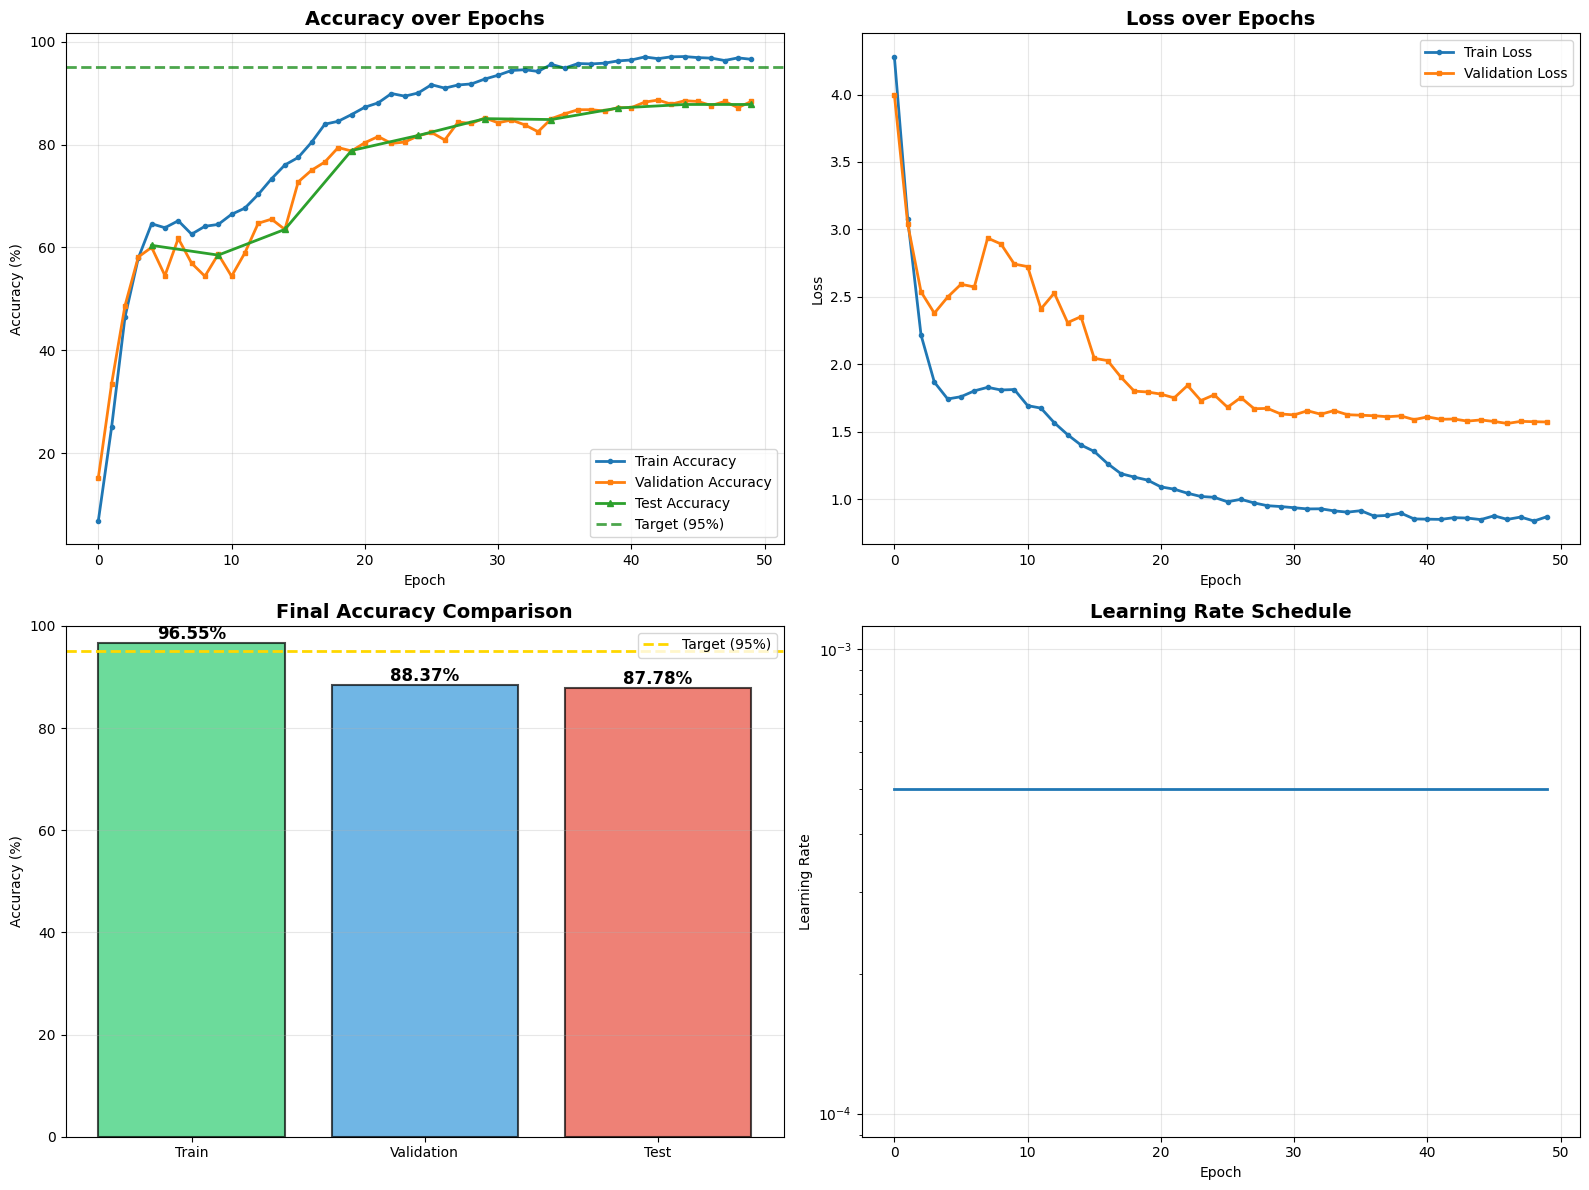


✓ Training visualization saved!


In [29]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Filter out zero values from test accuracy
test_acc_filtered = [acc for acc in test_acc_history if acc > 0]
test_epochs = [i for i, acc in enumerate(test_acc_history) if acc > 0]

# Accuracy plot
axes[0, 0].plot(train_acc_history, label='Train Accuracy', linewidth=2, marker='o', markersize=3)
axes[0, 0].plot(val_acc_history, label='Validation Accuracy', linewidth=2, marker='s', markersize=3)
if test_acc_filtered:
    axes[0, 0].plot(test_epochs, test_acc_filtered, label='Test Accuracy', linewidth=2, marker='^', markersize=4)
axes[0, 0].axhline(y=95, color='g', linestyle='--', label='Target (95%)', alpha=0.7, linewidth=2)
axes[0, 0].set_title('Accuracy over Epochs', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss plot
axes[0, 1].plot(train_loss_history, label='Train Loss', linewidth=2, marker='o', markersize=3)
axes[0, 1].plot(val_loss_history, label='Validation Loss', linewidth=2, marker='s', markersize=3)
axes[0, 1].set_title('Loss over Epochs', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Final comparison
datasets_list = ['Train', 'Validation', 'Test']
accuracies = [checkpoint['train_acc'], checkpoint['val_acc'], final_test_acc]
colors = ['#2ecc71', '#3498db', '#e74c3c']

bars = axes[1, 0].bar(datasets_list, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1, 0].axhline(y=95, color='gold', linestyle='--', linewidth=2, label='Target (95%)')
axes[1, 0].set_title('Final Accuracy Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Accuracy (%)')
axes[1, 0].set_ylim(0, 100)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)

# Learning rate schedule
lr_history = [5e-4]  # Starting LR
axes[1, 1].plot(lr_history * len(train_acc_history), linewidth=2)
axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Learning Rate')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(r'D:\SeedLink\training_results_final.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Training visualization saved!")


Inference Function

In [31]:
print("\n" + "="*60)
print("INFERENCE EXAMPLE")
print("="*60)

def predict_single_image(image_path, model, transform, classes, device):
    """Predict crop from a single image"""
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Predict
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probs = F.softmax(outputs, dim=1)
        top5_probs, top5_indices = torch.topk(probs, 5)
    
    # Display results
    print(f"\nImage: {image_path}")
    print(f"\nTop 5 Predictions:")
    for i in range(5):
        crop_name = classes[top5_indices[0][i].item()]
        confidence = top5_probs[0][i].item() * 100
        print(f"  {i+1}. {crop_name:20s} - {confidence:5.2f}%")
    
    return classes[top5_indices[0][0].item()], top5_probs[0][0].item()

# Test on a sample image
sample_image = r'D:\SeedLink\Agricultural-crops\Apple\Image_1.jpg'  # Change this path

if os.path.exists(sample_image):
    predicted_crop, confidence = predict_single_image(
        sample_image, 
        model, 
        val_test_transform, 
        classes, 
        device
    )
    print(f"\n✓ Predicted: {predicted_crop} ({confidence*100:.2f}% confidence)")
else:
    print(f"\n⚠️  Sample image not found: {sample_image}")


INFERENCE EXAMPLE

Image: D:\SeedLink\Agricultural-crops\Apple\Image_1.jpg

Top 5 Predictions:
  1. Apple                - 93.96%
  2. Amaranth             -  0.36%
  3. Chikoo               -  0.22%
  4. Sugarcane            -  0.20%
  5. Yam                  -  0.20%

✓ Predicted: Apple (93.96% confidence)


In [43]:
if 'test_acc_history' in locals() and test_acc_history:
    # Get last non-zero test accuracy
    test_accuracy = [acc for acc in test_acc_history if acc > 0][-1] if any(acc > 0 for acc in test_acc_history) else 0
else:
    # Option 2: Calculate test accuracy from scratch
    model.eval()
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    test_accuracy = 100 * test_correct / test_total
    print(f"Calculated Test Accuracy: {test_accuracy:.2f}%")

In [46]:
import json


model_info = {
    'model_name': 'Agricultural Crop Classifier',
    'architecture': 'EfficientNetV2-M',
    'version': '1.0.0',
    'num_classes': int(num_classes),
    'classes': classes,
    'input_size': '224x224',
    'preprocessing': {
        'resize': 224,
        'normalize_mean': [0.485, 0.456, 0.406],
        'normalize_std': [0.229, 0.224, 0.225],
        'data_augmentation': {
            'train': [
                'RandomResizedCrop',
                'RandomHorizontalFlip',
                'RandomVerticalFlip',
                'RandomRotation(30)',
                'ColorJitter',
                'RandomAffine',
                'RandomPerspective',
                'RandomGrayscale',
                'RandomErasing'
            ],
            'test': ['Resize', 'Normalize']
        }
    },
    'performance': {
        'test_accuracy': float(test_accuracy),  # Fixed: single value now
        'validation_accuracy': float(checkpoint.get('val_acc', 0)),
        'train_accuracy': float(checkpoint.get('train_acc', 0)),
        'test_loss': float(checkpoint.get('test_loss', 0)) if 'test_loss' in checkpoint else None,
        'validation_loss': float(checkpoint.get('val_loss', 0)) if 'val_loss' in checkpoint else None
    },
    'training': {
        'total_epochs': int(checkpoint.get('epoch', 0)),
        'optimizer': 'AdamW',
        'learning_rate': '5e-4',
        'scheduler': 'OneCycleLR',
        'batch_size': 64,
        'weight_decay': 1e-4,
        'label_smoothing': 0.1,
        'early_stopping_patience': 15
    },
    'dataset': {
        'train_samples': len(train_dataset),
        'validation_samples': len(val_dataset),
        'test_samples': len(test_dataset),
        'split_ratio': {'train': 0.75, 'val': 0.15, 'test': 0.10}
    },
    'hardware': {
        'device': str(device),
        'cuda_available': torch.cuda.is_available(),
        'gpu_name': torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'N/A'
    },
    'files': {
        'checkpoint': 'best_model.pth',
        'weights_only': 'agri_crop_model_final.pth',
        'complete_model': 'complete_model.pth',
        'classes': 'classes.pkl',
        'test_results': 'test_results.json',
        'model_info': 'model_info.json'
    },
    'deployment': {
        'framework': 'Flask',
        'api_endpoints': [
            '/api/predict',
            '/api/health',
            '/api/classes',
            '/api/recommendations/<crop_name>'
        ],
        'supported_formats': ['PNG', 'JPG', 'JPEG'],
        'max_file_size': '16MB'
    }
}

info_path = r'D:\SeedLink\model_info.json'
with open(info_path, 'w') as f:
    json.dump(model_info, indent=4, fp=f)

print(f"✓ model_info.json saved")

✓ model_info.json saved


In [47]:
print(f"\n{'='*60}")
print("MODEL INFO SUMMARY")
print(f"{'='*60}")
print(f"Model: {model_info['model_name']}")
print(f"Architecture: {model_info['architecture']}")
print(f"Classes: {model_info['num_classes']}")
print(f"Test Accuracy: {model_info['performance']['test_accuracy']:.2f}%")
print(f"Validation Accuracy: {model_info['performance']['validation_accuracy']:.2f}%")
print(f"Train Accuracy: {model_info['performance']['train_accuracy']:.2f}%")
print(f"Total Epochs: {model_info['training']['total_epochs']}")
print(f"Device: {model_info['hardware']['device']}")
print(f"{'='*60}")


MODEL INFO SUMMARY
Model: Agricultural Crop Classifier
Architecture: EfficientNetV2-M
Classes: 96
Test Accuracy: 87.78%
Validation Accuracy: 88.37%
Train Accuracy: 96.55%
Total Epochs: 49
Device: cuda
